densely connected network & convnet is have no memory.<br> process sequence or temporal series of data point => turn it into a single data point. => called <i>feedforward networks</i>

### pseudocode RNN, not run this cell
state_t = 0<br>
for input_t in input_sequence:<br>
&emsp;output_t = activation(dot(W, input_t) + dot(U, state_t) + b)<br>
&emsp;state_t = output_t

In [1]:
import numpy as np

timesteps = 100
input_features = 32
output_features = 64

In [4]:
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features, ))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features, ))

successive_outputs = []
for input_t in inputs:
    # implement pseudocode above
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    # store output in a list
    successive_outputs.append(output_t)
    state_t = output_t
    
# final output is 2D tensor (timesteps, output_features)
final_output_sequence = np.concatenate(successive_outputs, axis=0)

In [2]:
from keras.layers import SimpleRNN, Embedding
from keras.models import Sequential

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [6]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [3]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen = 500
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')
print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [8]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 35s 2ms/step - loss: 0.6436 - acc: 0.6134 - val_loss: 0.4771 - val_acc: 0.7860
Epoch 2/10
20000/20000 [==============================] - 38s 2ms/step - loss: 0.4471 - acc: 0.8058 - val_loss: 0.3861 - val_acc: 0.8384
Epoch 3/10
20000/20000 [==============================] - 30s 2ms/step - loss: 0.3210 - acc: 0.8706 - val_loss: 0.3571 - val_acc: 0.8602
Epoch 4/10
20000/20000 [==============================] - 38s 2ms/step - loss: 0.2789 - acc: 0.8910 - val_loss: 0.3583 - val_acc: 0.8488
Epoch 5/10
20000/20000 [==============================] - 37s 2ms/step - loss: 0.2077 - acc: 0.9231 - val_loss: 0.4144 - val_acc: 0.8490
Epoch 6/10
20000/20000 [==============================] - 31s 2ms/step - loss: 0.1777 - acc: 0.9338 - val_loss: 0.3814 - val_acc: 0.8500
Epoch 7/10
20000/20000 [==============================] - 30s 2ms/step - loss: 0.

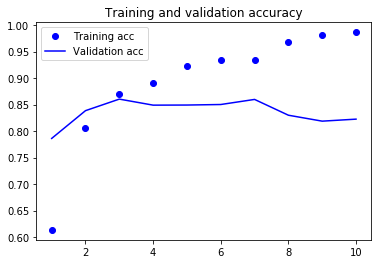

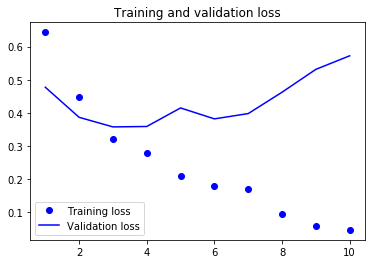

In [10]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Overfitting after 4 epochs and validation accuracy is not good.<br>
Because input only consider of first 500 words => RNN access less information.<br>
=> problem <b>SimpleRNN</b> isn't good at processing long sequences, such as text

# 6.2.2 Understanding the LSTM and GRU
Hạn chế của SimpleRNN: có thể lưu trạng thái của các state đằng trc nó, tuy nhiên bị dính <i>vanishing gradient problem</i>, khi quá nhiều state thì dẫn đến tình trạng nontrainable.
LSTM sinh ra để giải quyết việc này.<br>
Không làm đơn giản như SimpleRNN là để  output_t = state_t+1, LSTM phức tạp hơn khi có 1 carry track, cứ mỗi khi input_t vào thì ngoài state_t thì có thêm 1 input nữa từ carry track là c_t.<br>
Do vậy tính ra output_t phức tạp hơn khi:<br>
    &emsp;output_t = activation(dot(W, input_t) + dot(U, state_t) + dot(V, c_t) + b)<br>
    &emsp;c_t = i_t * k_t + c_t-1 * f_t<br>
Ta thấy rằng việc tính c_t cũng có các tham số, điều đó cho phép có thể  update cách tính c_t trong quá trình học. Nó giống như việc chọn lựa các thông tin nào tin cậy từ quá khứ và ảnh hưởng đến tương lai, chứ ko phải lấy tất cả thông tin từ quá khứ như SimpleRNN.<br>
Nhờ vậy LSTM khắc phục đc nhược điểm của SimpleRNN là vanishing-gradient problem.

# 6.2.3 thực hành LSTM trên keras

In [5]:
from keras.layers import LSTM
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer ='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________
